## Client exploratory data analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

client = pd.read_csv('data/client.csv')
client.drop(['marital', 'credit_default', 'mortgage'], axis=1, inplace=True)
client['education'] = client['education'].fillna('Unknown')
print(client.info())

outcome = pd.read_csv('data/campaign.csv', usecols=['client_id', 'campaign_outcome'])
print(outcome.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  41188 non-null  int64 
 1   age        41188 non-null  int64 
 2   job        41188 non-null  object
 3   education  41188 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   client_id         41188 non-null  int64
 1   campaign_outcome  41188 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 362.1 KB
None


## Age
The mean and median ages are 40.02 and 38 years, respectively. The shape of the age distribution does not appear to be normal, and the presence of outliers is evident. Several quantiles were calculated, revealing that 90% of the age data is under 55 years, 95% is under 58, and 99% is under 71. This skewed distribution, along with the presence of outliers, suggests that a small number of older individuals may disproportionately influence the mean, making the median a more reliable measure of central tendency for this variable.

Mean age: 40.02 years
Median age: 38.0 years


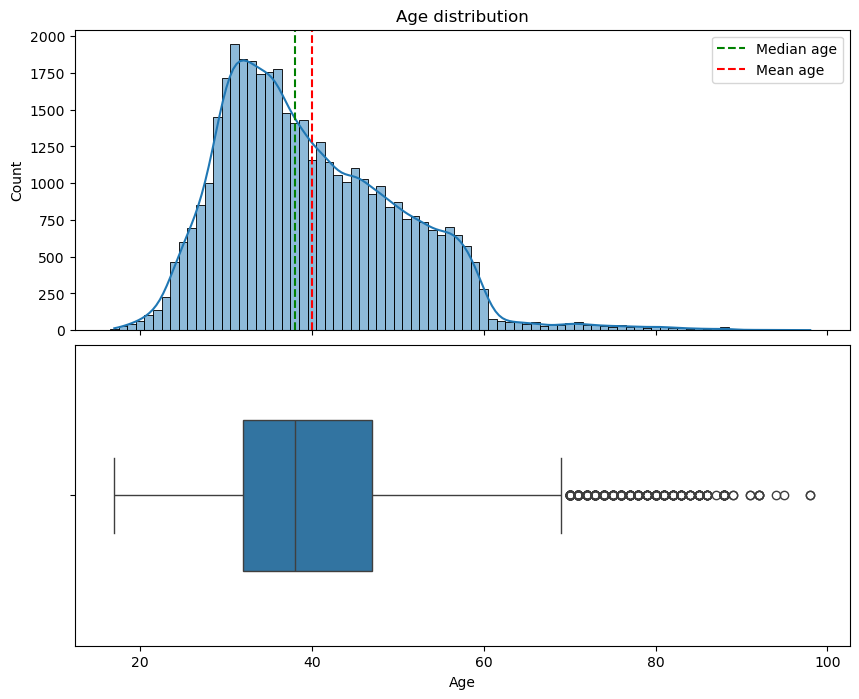

In [3]:
# Central tendency measures
mean_age = client['age'].mean()
median_age = client['age'].median()
print(f'Mean age: {round(mean_age, 2)} years')
print(f'Median age: {median_age} years')

# Age distribution
fig, ax = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
ax[0].set_title('Age distribution')
sns.histplot(x='age', data=client, discrete=True, kde=True, ax=ax[0])
ax[0].axvline(median_age, color='green', linestyle='--', label='Median age')
ax[0].axvline(mean_age, color='red', linestyle='--', label='Mean age')
ax[0].legend()

# Boxplot and potential age outliers
sns.boxplot(x='age', data=client, width=0.5, ax=ax[1])
ax[1].set_xlabel('Age')
plt.subplots_adjust(hspace=0.05)
plt.show()

In [4]:
# Quantiles calculation
quantiles = [0.90, 0.95, 0.99]
ages = np.quantile(client['age'], quantiles)
result = [f'Data under {round(age)} years: {q*100}% of data points.' for q, age in zip(quantiles, ages)]
print(*result, sep='\n')

Data under 55 years: 90.0% of data points.
Data under 58 years: 95.0% of data points.
Data under 71 years: 99.0% of data points.


The following code calculates ten quantiles for the age variable and plots them using an empirical cumulative distribution function (ECDF). This step is part of an effort to segment the data by age, using quantile-based binning. The resulting distribution, however, did not resemble the original histogram, an issue that will be discussed later.

Quantile 1: 28.0 years.
Quantile 2: 31.0 years.
Quantile 3: 33.0 years.
Quantile 4: 35.0 years.
Quantile 5: 38.0 years.
Quantile 6: 41.0 years.
Quantile 7: 45.0 years.
Quantile 8: 49.0 years.
Quantile 9: 55.0 years.
Quantile 10: 98.0 years.


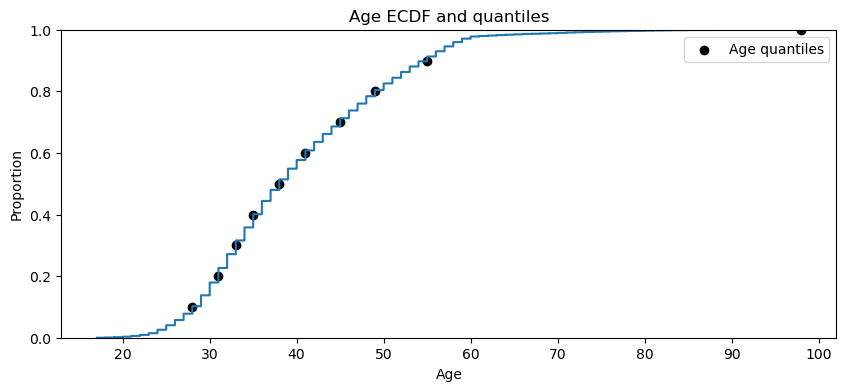

In [5]:
# Empirical cumulative density function and quantiles

# Quantiles
proportions = np.linspace(0.1, 1, 10)
age_quantiles = np.quantile(client['age'], proportions)

# Create a column for age ranges based on quantiles
labels = [f'Q{i}' for i in range(1, 11)]
client['age_quantiles'] = pd.qcut(client['age'], q=10, labels=labels)

# Show the quantiles
result = [f'Quantile {i}: {q} years.' for i, q in enumerate(age_quantiles, start=1)]
print(*result, sep='\n')

# Plot
plt.figure(figsize=(10, 4))
plt.title('Age ECDF and quantiles')
sns.ecdfplot(x='age', data=client)
plt.scatter(age_quantiles, proportions, color='black', label='Age quantiles')
plt.xlabel('Age')
plt.legend()
plt.show()

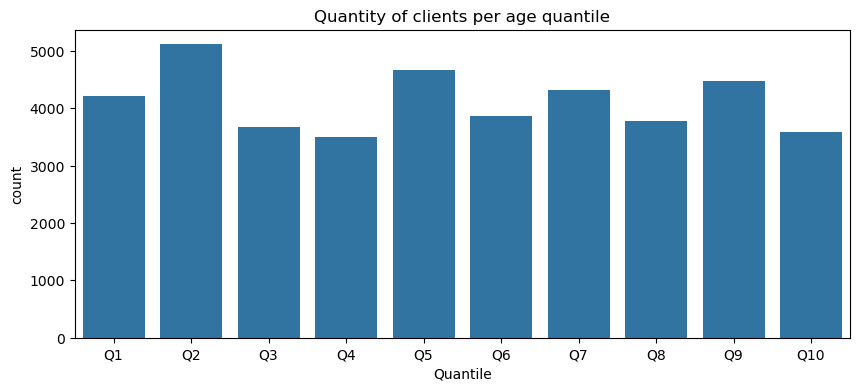

In [6]:
# Plot the distribution based on quantiles
plt.figure(figsize=(10, 4))
plt.title('Quantity of clients per age quantile')
sns.countplot(x='age_quantiles', data=client)
plt.xlabel('Quantile')
plt.show()

A different result emerges when the bins are based on the shape of the original distribution, rather than on quantiles. In this dataset, the typical user is between 18 and 64 years old. The approach here involved creating seven custom bins, taking age outliers into account by grouping most of them into the final range (75–98). Unlike the quantile-based split —which produced bins that didn’t reflect the true shape of the data— this method aligns much more closely with the underlying distribution. As a result, the segmentation is more informative and better suited for further analysis.

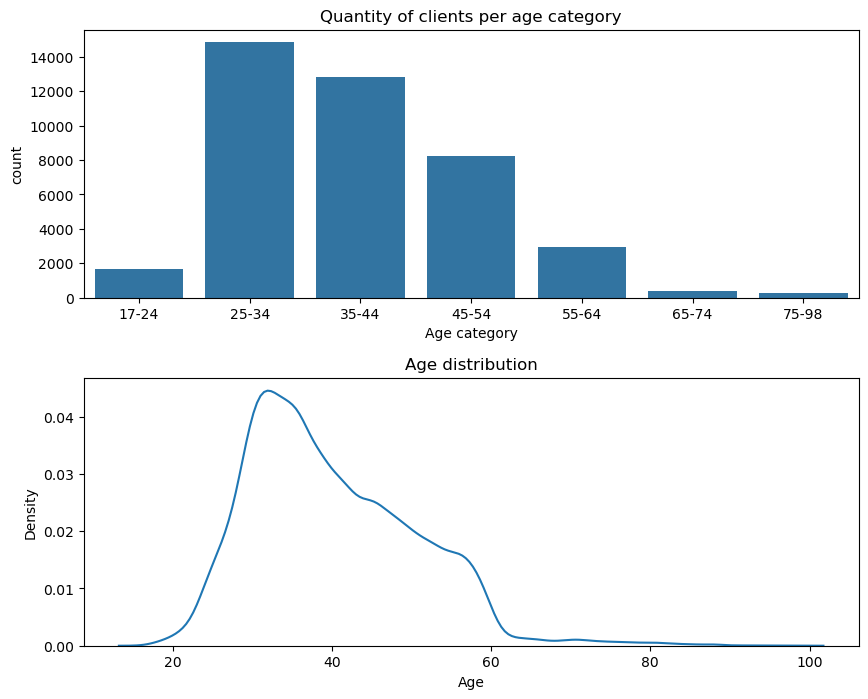

In [7]:
# Create ranges based on custom categories
bins = [17, 25, 35, 45, 55, 65, 75, 98]
labels = ['17-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-98']
client['age_custom'] = pd.cut(client['age'], bins=bins, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8), nrows=2)

ax[0].set_title('Quantity of clients per age category')
ax[0].set_xlabel('Age category')
sns.countplot(x='age_custom', data=client, ax=ax[0])

ax[1].set_title('Age distribution')
ax[1].set_xlabel('Age')
sns.kdeplot(x='age', data=client, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

## Campaign outcome

In [8]:
# Add campaign result for further analysis
merged = client[['client_id', 'job', 'education', 'age_custom']].merge(outcome, on='client_id')
merged['campaign_outcome'] = merged['campaign_outcome'].apply(lambda x: 'success' if x==1 else 'failure')

# Crosstabs
cross_age = pd.crosstab(merged['age_custom'], merged['campaign_outcome'], normalize='index')
cross_job = pd.crosstab(merged['job'], merged['campaign_outcome'], normalize='index')
cross_edu = pd.crosstab(merged['education'], merged['campaign_outcome'], normalize='index')

age_order = cross_age.index.tolist()
job_order = cross_job.index.tolist()
edu_order = cross_edu.index.tolist()

print(cross_age.shape)
print(cross_job.shape)
print(cross_edu.shape)

(7, 2)
(12, 2)
(8, 2)


### Customers and age

The main age categories —customers aged 25 to 54— make up 87.27% of the dataset. Within this group, the most representative segment is the 25-34 age range, accounting for 36% of the total.
The stacked bar chart shows that, although the success rate is relatively high among the 17-24, 65-74, and 75-98 age groups, these groups appear infrequently in the dataset.
Among the three largest age segments, the most represented group (25-34) also has the highest success proportion, with 11.71%.

Sum of the main age categories: 87.27%


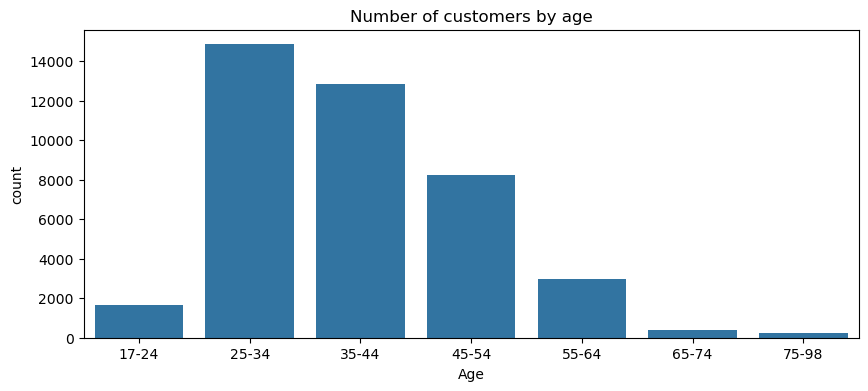

In [9]:
# Main categories
prop = merged['age_custom'].value_counts(normalize=True)[:3].sum()
print(f'Sum of the main age categories: {round(prop*100, 2)}%')

# Count of customers by age
plt.figure(figsize=(10, 4))
plt.title('Number of customers by age')
sns.countplot(x='age_custom', data=client)
plt.xlabel('Age')
plt.show()

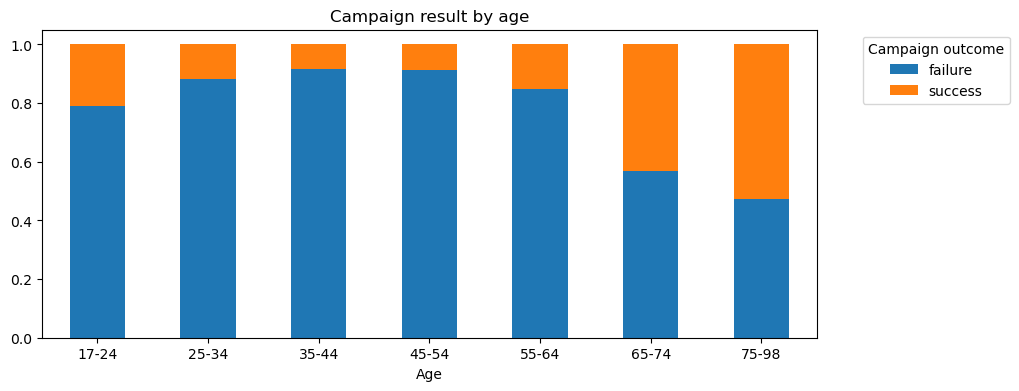

In [10]:
# 100% Stacked bar chart of age category and campaign result
cross_age.plot(kind='bar', stacked=True, figsize=(10, 4), title='Campaign result by age')
plt.xlabel('Age')
plt.legend(title='Campaign outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Customers and job

The main job categories are admin, blue-collar, technician and services, in order of representativeness, and together they account for 73.78% of the total. Among these, the admin group shows the highest success rate, with 12.97%.
A similar pattern to the age variable is observed here: while the student and retired categories have notably high success rates (31.42% and 25.23%, respectively), they represent a small portion of the dataset.

Sum of the main job categories: 73.78%


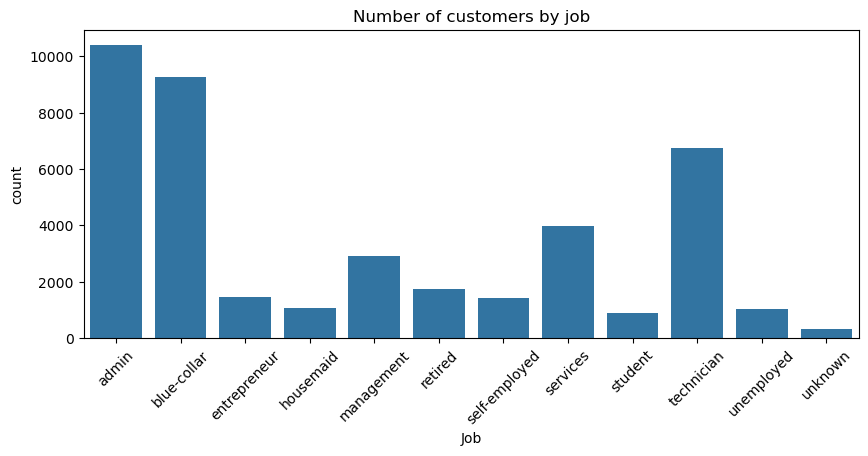

In [11]:
# Main categories
prop = merged['job'].value_counts(normalize=True)[:4].sum()
print(f'Sum of the main job categories: {round(prop*100, 2)}%')

# Count of customers by job
plt.figure(figsize=(10, 4))
plt.title('Number of customers by job')
sns.countplot(x='job', data=client, order=job_order)
plt.xlabel('Job')
plt.xticks(rotation=45)
plt.show()

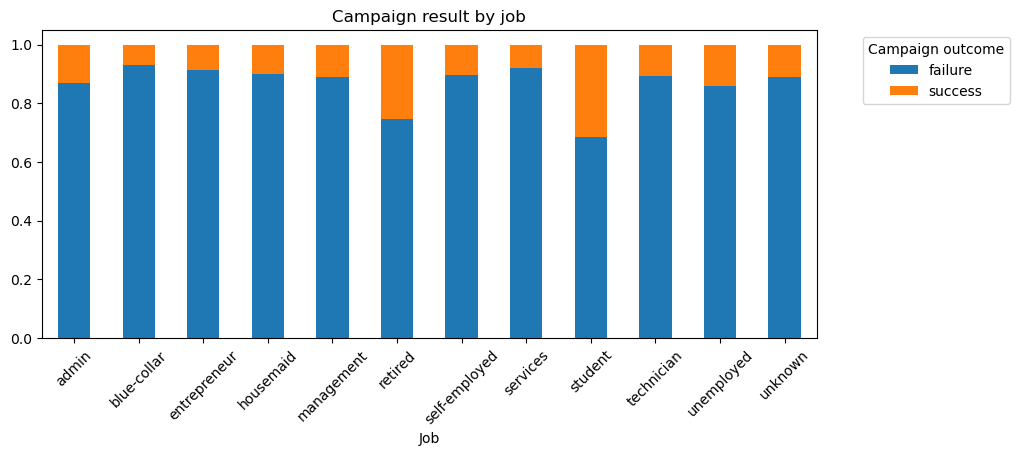

In [12]:
# 100% Stacked bar chart of job category and campaign result
cross_job.plot(kind='bar', stacked=True, figsize=(10, 4), title='Campaign result by job')
plt.xlabel('Job')
plt.xticks(rotation=45)
plt.legend(title='Campaign outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Customers and education
Unlike the previous cases, where the main categories were easily identifiable from the plot, a different approach was applied to select the main education categories.
In this case, a threshold of 85% was set, and the selection was based on the cumulative sum of relative frequencies. The categories were included sequentially until the cumulative total reached the defined threshold.

In [13]:
from my_code import MainCategories
cat_obj = MainCategories(merged['education'], 0.85)
limit = cat_obj.limit
cats = cat_obj.categories
print(cats)
print(limit)

['university_degree', 'high_school', 'basic_9y', 'professional_course']
4


There are four education categories that fall under the defined 85% threshold: university degree, high school, basic 9 years, and professional course, listed in order of relative frequency.
The university category is the most representative, accounting for 29.54% of the total, and it also shows the highest success rate among the main education groups, with 13.72%.
The illiterate category follows a pattern similar to other low-frequency categories previously observed — despite its small size, it has a notably high success rate.
It's worth noting that the highest success rates are consistently found in categories that are less frequent in the dataset. 

Sum of the main education categories: 80.05%
university_degree — high_school — basic_9y — professional_course


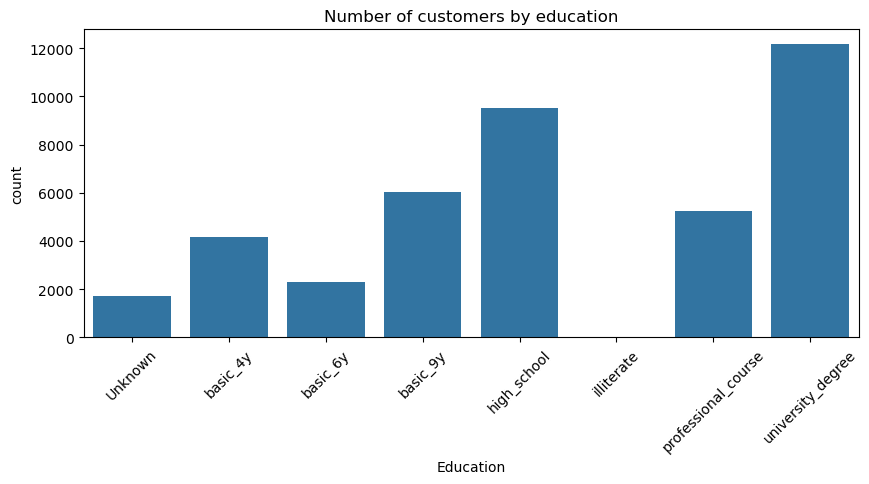

In [14]:
# Main categories
prop = cat_obj.cum_freq
print(f'Sum of the main education categories: {round(prop*100, 2)}%')
print(*cats, sep=' — ')

# Count of customers by education
plt.figure(figsize=(10, 4))
plt.title('Number of customers by education')
sns.countplot(x='education', data=client, order=edu_order)
plt.xlabel('Education')
plt.xticks(rotation=45)
plt.show()

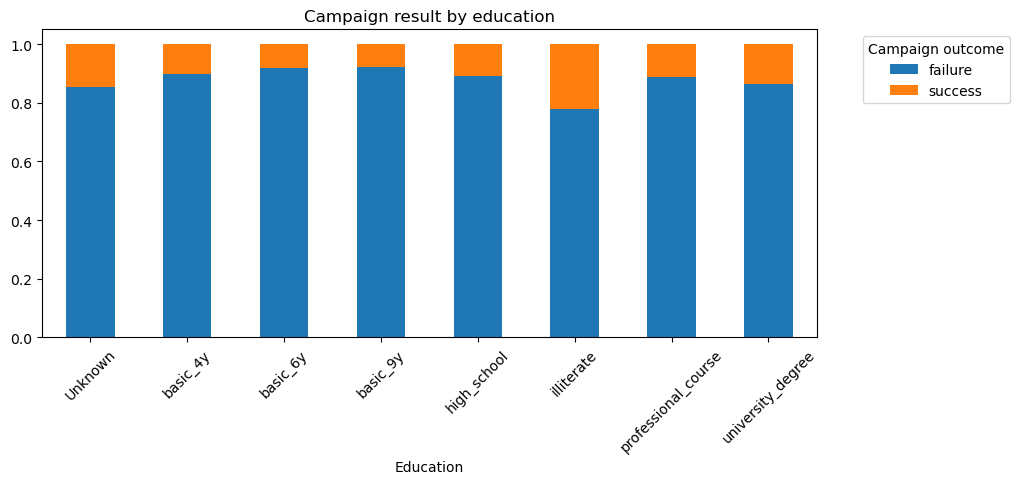

In [15]:
# 100% Stacked bar chart of education category and campaign result
cross_edu.plot(kind='bar', stacked=True, figsize=(10, 4), title='Campaign result by education')
plt.xlabel('Education')
plt.xticks(rotation=45)
plt.legend(title='Campaign outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()